# Plotting Pandapower Networks

This tutorial shows you how to plot pandapower networks. 

We use matplotlib collections to plot the stations or lines in the network. There are different types of elements in matplotlib, like lines, circles, rectangles etc. These elements are bundled into collections, where one objects holds many elements of the same type (see matplotlib documentation: http://matplotlib.org/api/collections_api.html).

The plotting module provides several functions that create collections from pandapower networks. In this interactive tutorial, we show you how to use these functions to plot networks.

## Simple Plotting

There is a convenience function that allows you to plot networks fast without having to gain an in depths understanding of the pandapower plotting module. The simple_plot function can be called as follows:

tazan.pandapower.plotting.collections - WARNING: None in collections is of unknown type. Skipping
tazan.pandapower.plotting.collections - WARNING: None in collections is of unknown type. Skipping


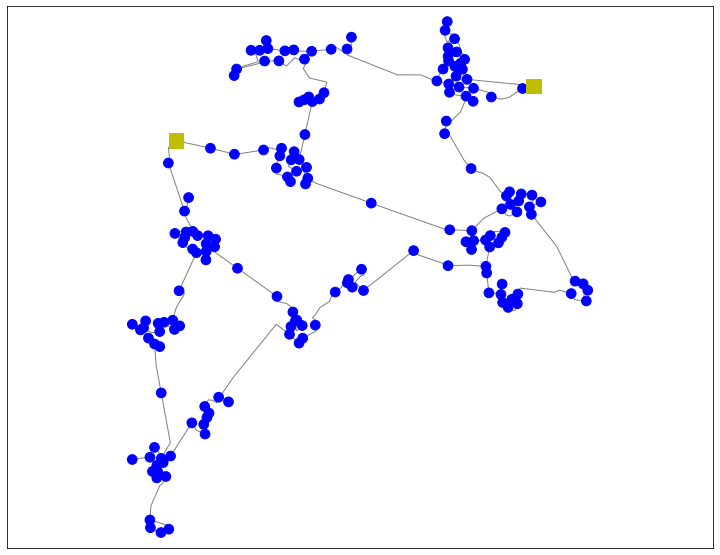

In [3]:
import pandapower.plotting as plot
import pandapower.networks as nw

# load example net (IEEE 9 buses)
net = nw.mv_oberrhein()
# simple plot of net with existing geocoordinates or generated artificial geocoordinates
plot.simple_plot(net, show_plot=True)

This function plots geodata if it is available and generates generic geodata if none is available. Note that you need the python-igraph package to generate geocoordinates (see last chapter of this tutorial).



## Plotting Collections

If you want to have full control over the layout of your plot, you can individually create and plot collections with the pandapower plotting module.

In [4]:
import matplotlib.pyplot as plt
import os
import pandapower as pp
import pandapower.plotting as plot
import pandapower.networks as nw
try:
    import seaborn
    colors = seaborn.color_palette()
except:
    colors = ["b", "g", "r", "c", "y"]
%matplotlib inline

First, we plot only the lines and buses of an example network. This is done by creating a line collection for all lines and a bus collection for all buses. We then plot both collections with the draw_collections function:

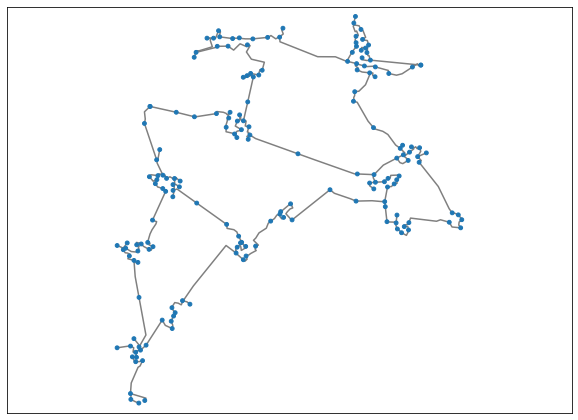

In [5]:
net = nw.mv_oberrhein()
lc = plot.create_line_collection(net, net.line.index, color="grey", zorder=1) #create lines
bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=2) #create buses
plot.draw_collections([lc, bc], figsize=(8,6)) # plot lines and buses

## Plot Bus IDs

Bus indices (names, or other annotations) can be plotted by creating an additional collection.

In this example, we plot all bus indices. Therefore we create a new collection (bic) with create_annotation_collection.
For this we need a list of strings (Texts) which contain the texts to plot and their coordinates (coords, tuples of coordinates).

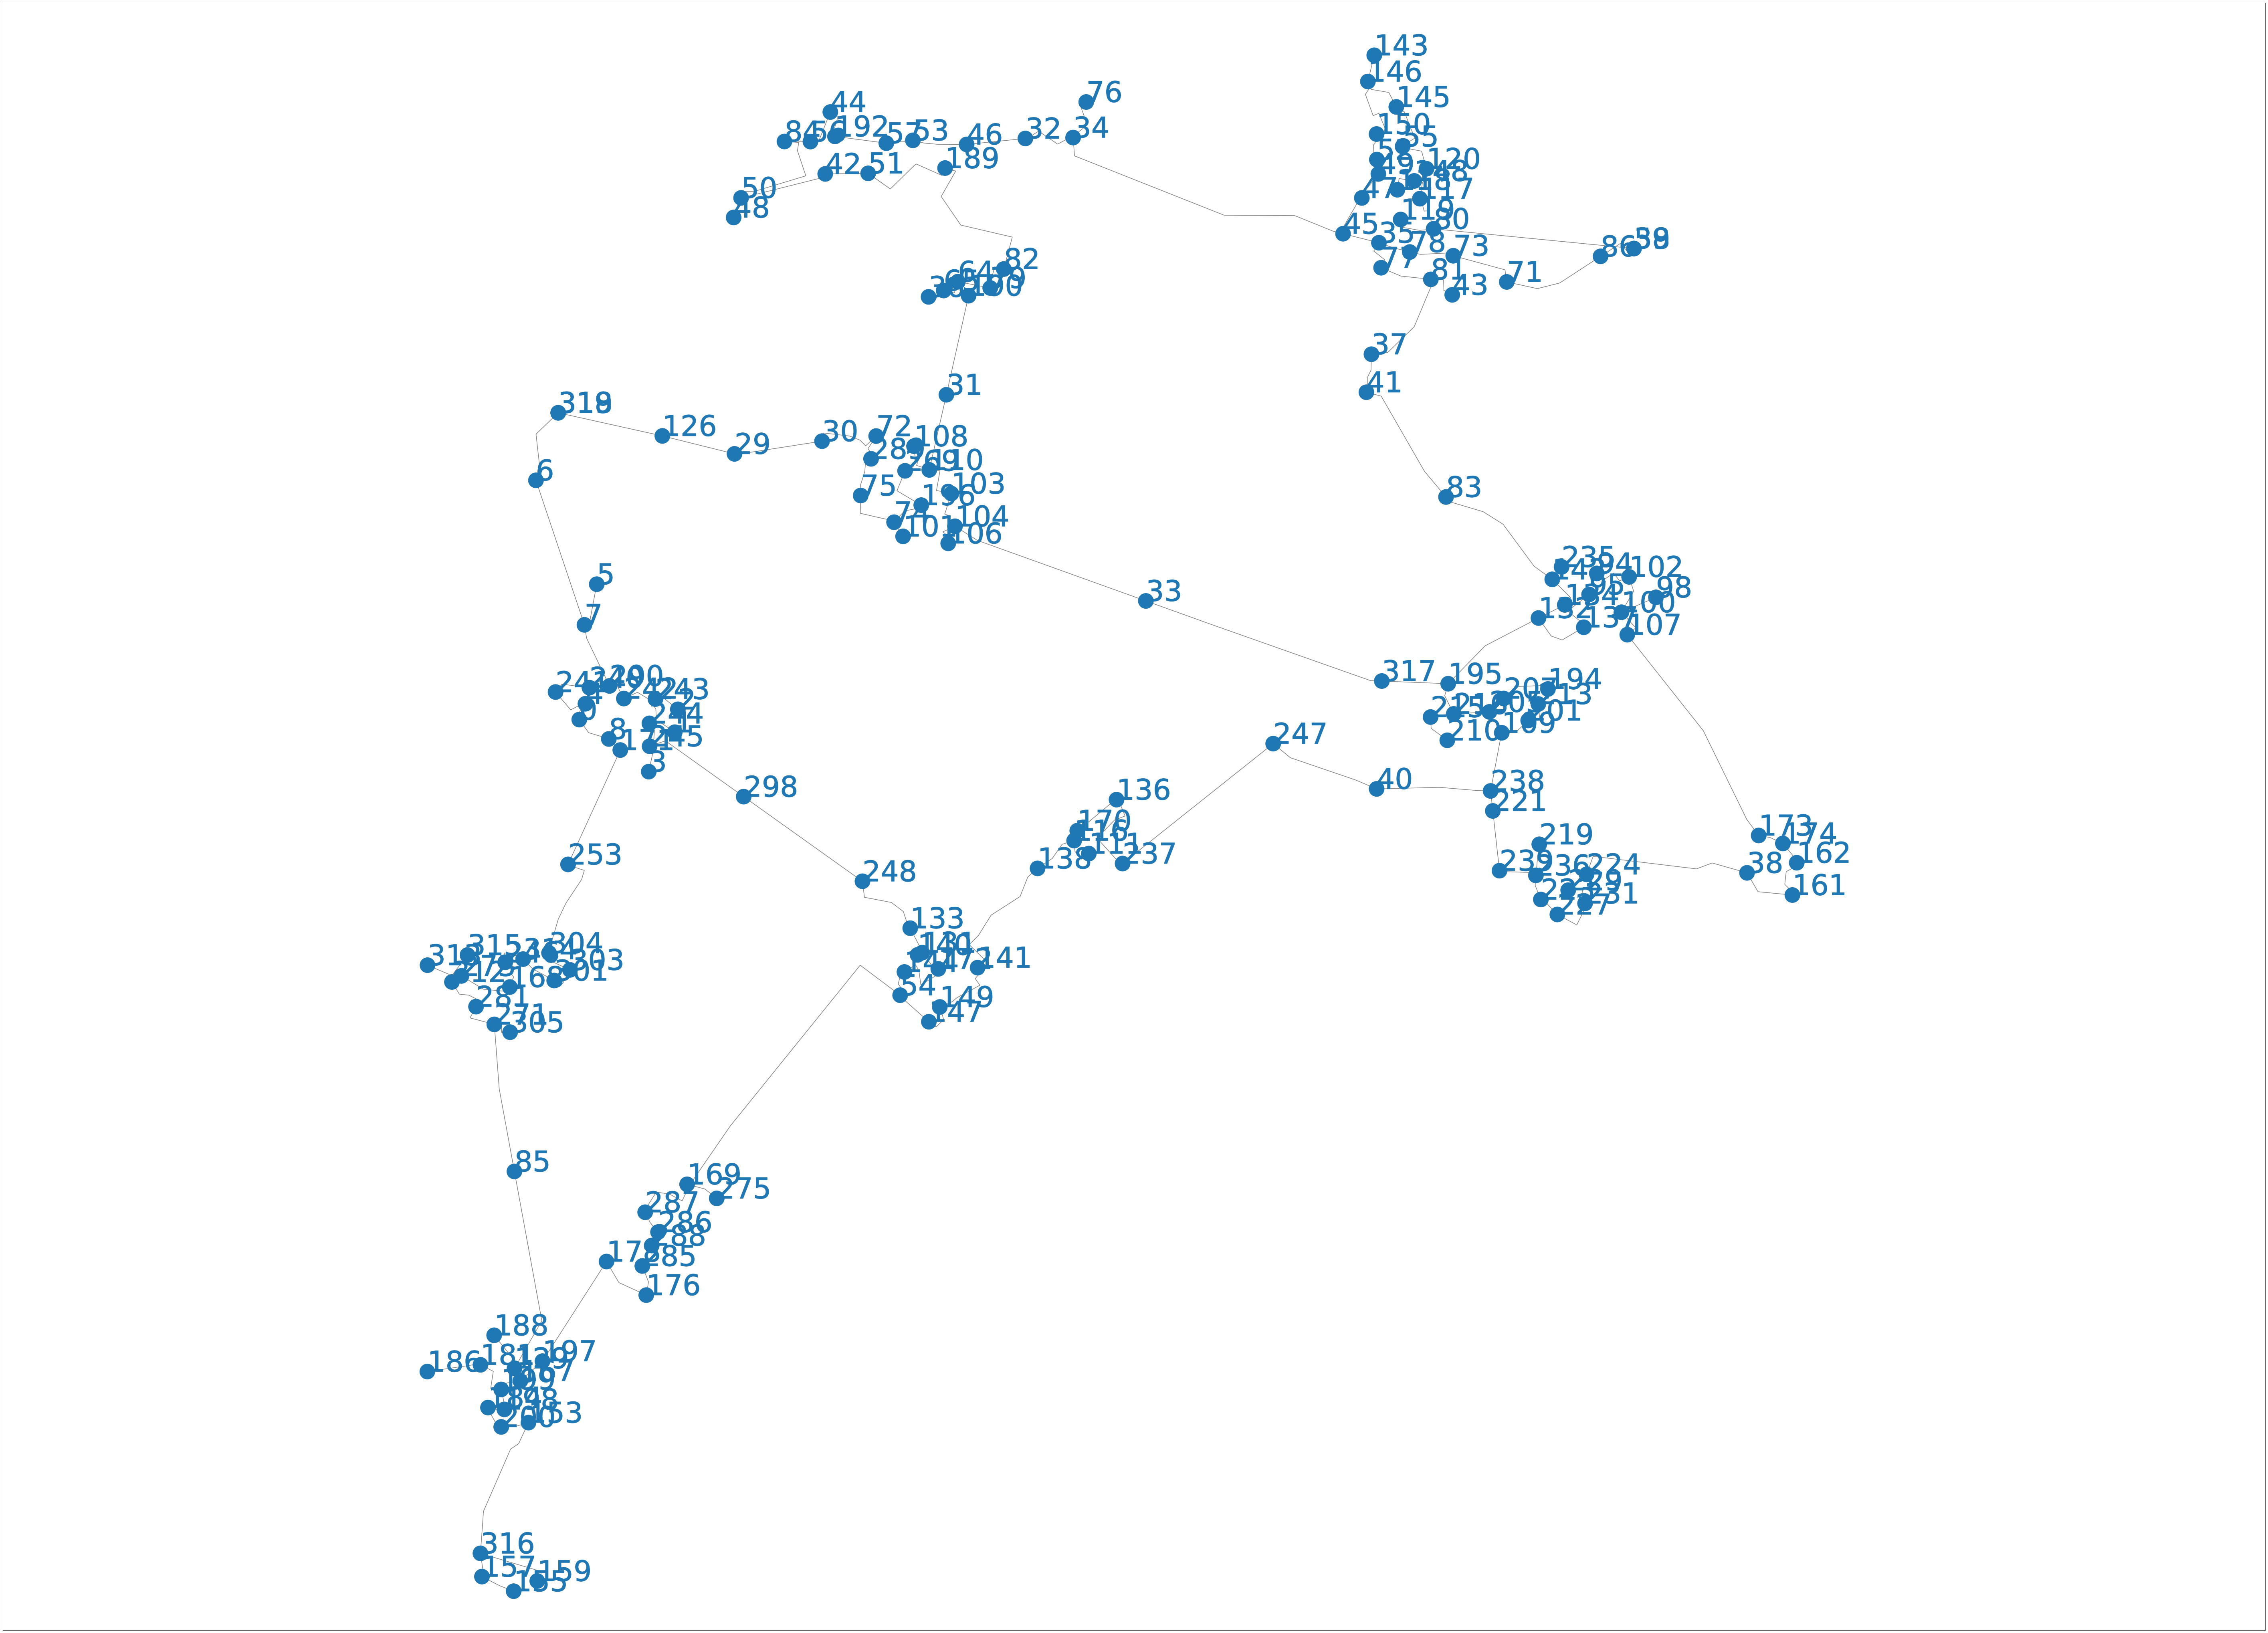

In [6]:
import numpy as np
buses = net.bus.index.tolist() # list of all bus indices
coords = zip(net.bus_geodata.x.loc[buses].values, net.bus_geodata.y.loc[buses].values) # tuples of all bus coords

bic = plot.create_annotation_collection(size=300, texts=np.char.mod('%d', buses), coords=coords, zorder=3, color=colors[0])
plot.draw_collections([lc, bc, bic], figsize=(80,60)) # plot lines, buses and bus indices

## Highlighting

Specific lines or buses can be highlighted by creating extra line collections in different colors.

In this example, we plot lines that are longer than 2 km green and buses with a voltage below 0.98 pu red.

First, we create a line collection for all lines in grey and a line collection for only the long lines in green:

In [7]:
net = nw.mv_oberrhein()
long_lines = net.line[net.line.length_km > 2.].index
lc = plot.create_line_collection(net, net.line.index, color="grey", zorder=1)
lcl = plot.create_line_collection(net, long_lines, color="g", zorder=2)

Notice that the zorder is higher for the long line collection. This ensures that the green line collection is plotted over the grey line collection.

We then conduct a loadflow and create bus collections in the same way:

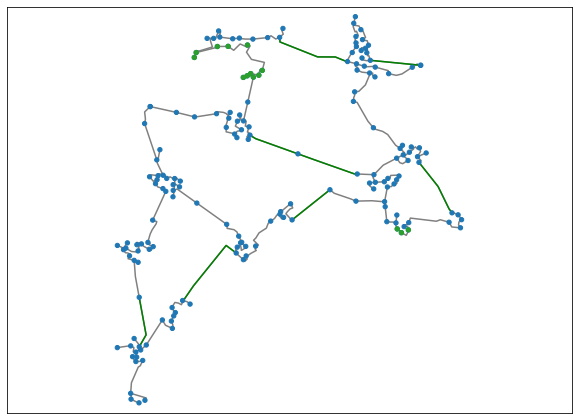

In [8]:
pp.runpp(net)
low_voltage_buses = net.res_bus[net.res_bus.vm_pu < 0.98].index
bc = plot.create_bus_collection(net, net.bus.index, size=90, color=colors[0], zorder=10)
bch = plot.create_bus_collection(net, low_voltage_buses, size=90, color=colors[2], zorder=11)
plot.draw_collections([lc, lcl, bc, bch], figsize=(8,6))

Another way to highlight something is to use a different shape using the patch_type argument of the create_bus collection. You can for example mark the slack bus with a rectangle shape like this:

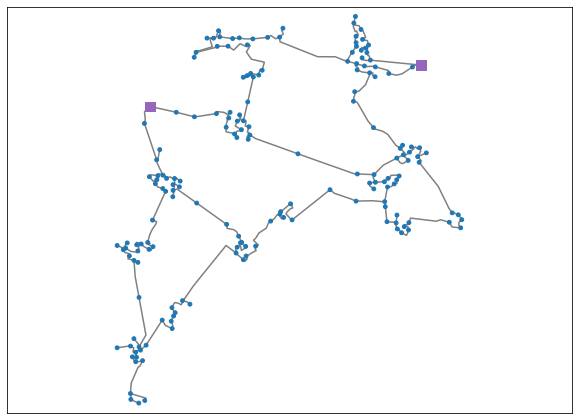

In [9]:
net = nw.mv_oberrhein()
lc = plot.create_line_collection(net, net.line.index, color="grey", zorder=1) #create lines
bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=2) #create buses
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200, color=colors[4], zorder=11)
plot.draw_collections([lc, bc, sc], figsize=(8,6)) # plot lines and buses

## Highlighting with the Topology Package

Combining the [topology package](topology.ipynb) with the plotting package allows highlighting of structural features of the network. For example, we can highlight all buses closer than 5 km to a transformer station:

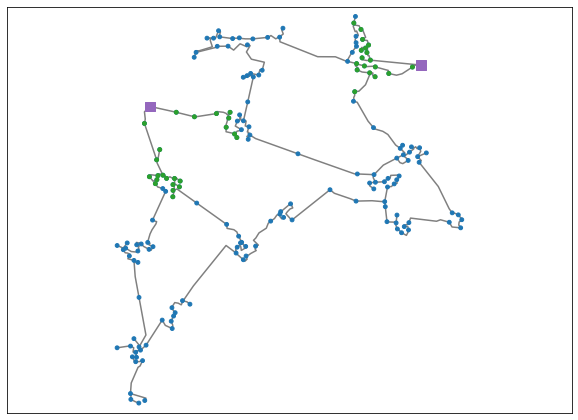

In [10]:
net = nw.mv_oberrhein()
close_buses = set()
for slack in net.ext_grid.bus:
    d = pp.topology.calc_distance_to_bus(net, slack)
    close_buses |= set(d[d < 5].index)

bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=1)
bch = plot.create_bus_collection(net, close_buses, size=80, color=colors[2], zorder=2)
lc = plot.create_line_collection(net, net.line.index, zorder=1, color="grey")
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200, color=colors[4], zorder=11)
plot.draw_collections([lc, bc, bch, sc], figsize=(8,6))

Or to highlight the radiality of the network, plot the seperate feeders in different colors:

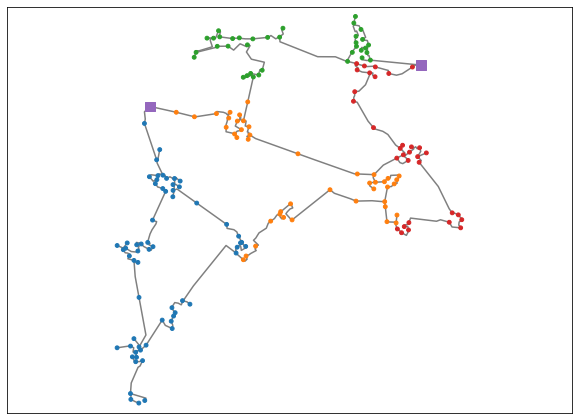

In [11]:
net = nw.mv_oberrhein()
mg = pp.topology.create_nxgraph(net, nogobuses=set(net.trafo.lv_bus.values) | set(net.trafo.hv_bus.values))
collections = []
for color, area in zip(colors, pp.topology.connected_components(mg)):
    collections.append(plot.create_bus_collection(net, area, size=80, color=color, zorder=2))
collections.append(plot.create_line_collection(net, net.line.index, zorder=1, color="grey"))
collections.append(plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200,
                                              color=colors[4], zorder=11))
plot.draw_collections(collections, figsize=(8,6))

## Direct Line Connections

Line collections are plotted with the geographical coordinates of the lines that are stored in net.line_geodata by default. You can also plot lines as direct connections between the buses, by calling the create_line_collection function with use_bus_geodata=True:

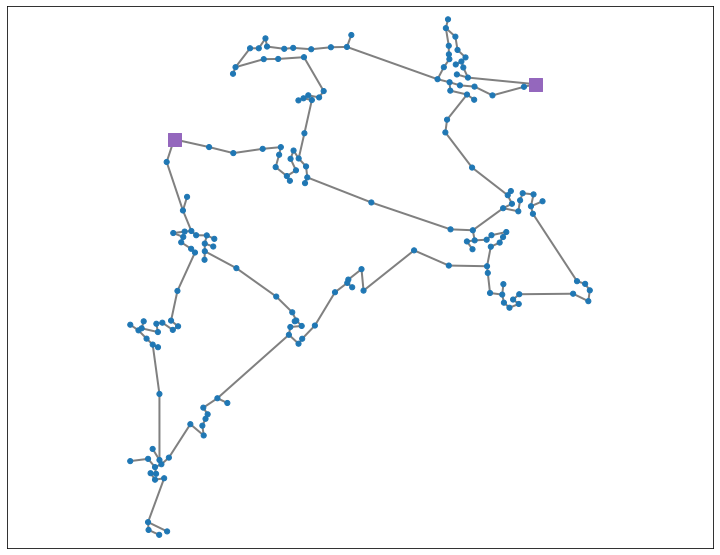

In [14]:
net = nw.mv_oberrhein()
bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=10)
lcd = plot.create_line_collection(net, net.line.index, use_bus_geodata=True, color="grey", linewidths=2.)
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200,
                                              color=colors[4], zorder=11)
plot.draw_collections([lcd, bc, sc])

As a comparison, here are the lines with direct connections (solid) and the line trails from line_geodata (dashed):

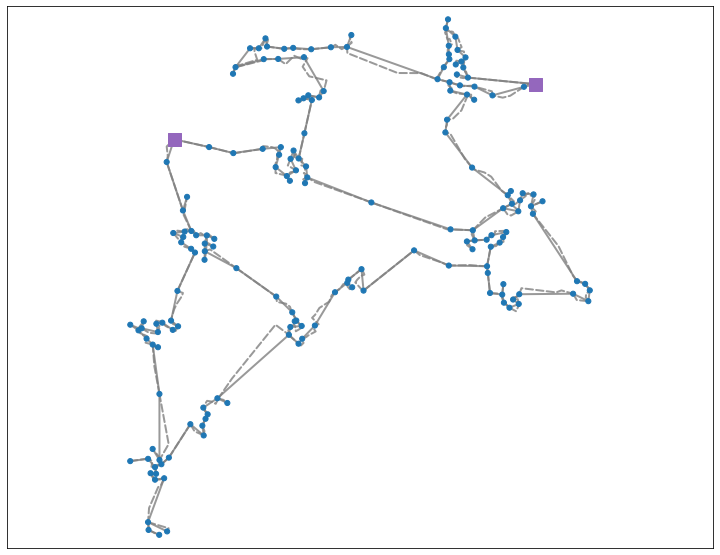

In [17]:
net = nw.mv_oberrhein()
bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=10)
lcd = plot.create_line_collection(net, lines=net.line.index, color="grey",alpha=0.8, linewidths=2., use_bus_geodata=True)
lc = plot.create_line_collection(net, lines=net.line.index, color="grey",alpha=0.8, linestyles="dashed", linewidths=2.)
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200,
                                              color=colors[4], zorder=11)
plot.draw_collections([lc, lcd, bc, sc])